In [2]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import pandas as pd
import cv2

from  torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import torch
import torch.nn as nn

In [3]:
'''
0 -> 2
1 -> 0
2 -> 1
3 -> 3
'''

gpu_number = 3
# device = torch.device(device=f'cuda:{gpu_number}')
device = torch.device('cpu') #debug purposes
device

device(type='cpu')

In [4]:
path_to_data = "/DATA/asaginbaev/CourseOCRTask3" # we decided to share data

In [5]:
train_path = Path('/') / path_to_data / 'Train'
test_path = Path('/') / path_to_data / 'Test'

In [6]:
len(os.listdir(train_path / 'Images'))

8393

In [7]:
os.listdir(train_path)

['Images', 'markup.csv', 'Inverted', 'markup_wo_inverted.csv']

In [8]:
names = ['filename', 'number', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'code']
df = pd.read_csv(train_path / 'markup.csv', encoding='utf-16', header=None, names=names)

train_df = df[:6000]
val_df = df[6000:].reset_index()

In [17]:
class hw3dataset(Dataset):
    def __init__(self, df, path, device):
        self.device = device
        self.items = []
        for idx, row in tqdm(df.iterrows()):
            image_path = path / 'Images' / row['filename']
            if os.path.exists(image_path):
                img = np.array(Image.open(image_path)) / 255.
                vertices = np.array([[row['x1'], row['y1']], [row['x2'], row['y2']], [row['x3'], row['y3']], [row['x4'], row['y4']]])
                mask = cv2.fillConvexPoly(np.zeros(img.shape[:2]), vertices, (1,))[np.newaxis, ...]
                self.items.append((img, mask))
            if idx == 3:
                break
            
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        img, mask = self.items[idx]
        return torch.tensor(img.transpose(2, 0, 1), dtype=torch.float, device=device),\
                torch.tensor(mask, dtype=torch.float, device=device)

In [18]:
train_data = hw3dataset(train_df, train_path, device)
val_data = hw3dataset(val_df, train_path, device)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
batch_size=1
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [20]:
for batch in train_dl:
    break

In [21]:
# model from hw1

class enc_conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.block(x)
    
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.dec_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, u, e):
        u = self.upsample(u)
        pad_w = e.shape[2] - u.shape[2]
        pad_h = e.shape[3] - u.shape[3]
        padding = [pad_h // 2, pad_h - pad_h // 2, pad_w // 2, pad_w - pad_w // 2]
        u = nn.functional.pad(u, padding)
        return self.dec_conv(torch.cat((e, u), dim=1))
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.enc_conv0 = enc_conv_block(3, 64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = enc_conv_block(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = enc_conv_block(128, 256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = enc_conv_block(256, 512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = enc_conv_block(512, 1024)

        # decode
        self.up_0 = upsample_block(1024+512, 512)
        self.up_1 = upsample_block(512+256, 256)
        self.up_2 = upsample_block(256+128, 128)
        self.up_3 = upsample_block(128+64, 64)
        
        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) 

        # decoder
        u0 = self.up_0(b, e3)
        u1 = self.up_1(u0, e2)
        u2 = self.up_2(u1, e1)
        u3 = self.up_3(u2, e0)
        
        out = self.out(u3)
        return out
unet_model = UNet().to(device)

In [22]:
from time import time
from IPython.display import clear_output

In [29]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in tqdm(data_tr):

            opt.zero_grad()
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss.item())
        
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu()

        val_loss_sum = 0
        for X_val_batch, Y_val_batch in tqdm(data_val):
            with torch.set_grad_enabled(False):
                Y_pred_batch = model(X_val_batch)
                loss = loss_fn(torch.sigmoid(Y_pred_batch), Y_val_batch)
                prediction = torch.sigmoid(Y_pred_batch) > 0.5
            val_loss_sum += loss
        val_loss.append((val_loss_sum/len(data_val)).item())

        clear_output(wait=True)
        plt.figure(figsize = (16, 7))
        plt.title('Loss')
        plt.plot(train_loss, label='train loss')
        plt.plot(val_loss, label='val loss')
        plt.legend()
        plt.show()

        clear_output(wait=True)
        print(len(X_val))
        for k in range(1):
            plt.subplot(2, 1, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 1, k+2)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'epoch{epoch}.pth')

    return train_loss, val_loss

1


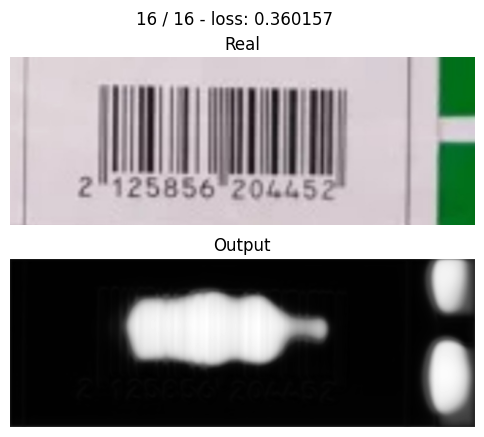

In [30]:
unet_train_loss, unet_val_loss = train(unet_model, torch.optim.Adam(unet_model.parameters()), nn.BCELoss(), 16, train_dl, val_dl)